<a href="https://colab.research.google.com/github/sina-salmanpour/Loan_Defaults_prediction/blob/main/Loan_Defaults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
from IPython.core.interactiveshell import InteractiveShell

Libraries initial settings

In [ ]:
## Following lines are used to control how warnings are displayed.

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)  # warnings about features that will change in the future.
warnings.simplefilter(action="ignore", category=Warning)        # more general category for warnings.


## Setting below is related to how IPython displays output.
## The results of all statements in a cell that would normally be displayed are shown

InteractiveShell.ast_node_interactivity = "all"

# matplotlib plots are displayed directly within the notebook output

%matplotlib inline
np.set_printoptions(suppress=True)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")

def set_seed(seed=42):
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 25)
pd.set_option("display.float_format", lambda x: "%.3f" % x)


Loading Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Loan Defaults/Dataset ARCHIVE/Training Data.csv')

Checking for missing values and duplicated values

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print("Missing Values:")
    print(missing_values[missing_values > 0])

    # Calculate missing value percentages
    missing_percent = (missing_values / len(df)) * 100
    print("\nMissing Value Percentages:")
    print(missing_percent[missing_percent > 0])

No missing values found in the dataset.


In [ ]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
if duplicate_rows == 0:
    print("\nNo duplicate rows found in the dataset.")
else:
    print(f"\nNumber of duplicate rows found: {duplicate_rows}")


No duplicate rows found in the dataset.


Initial inspection

In [ ]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget variable distribution:")
print(df['Risk_Flag'].value_counts())

Dataset Shape: (252000, 13)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB
None

First 5 rows:
   Id   Income  Age  Experience Married/Single House_Ow

In [ ]:
print("Summary Statistics (Numerical Features):\n")
df.describe().T   # For Numerical variables

Summary Statistics (Numerical Features):



,count,mean,std,min,25%,50%,75%,max
Id,252000.000,126000.500,72746.278,1.000,63000.750,126000.500,189000.250,252000.000
Income,252000.000,4997116.665,2878311.014,10310.000,2503015.000,5000694.500,7477502.000,9999938.000
Age,252000.000,49.954,17.064,21.000,35.000,50.000,65.000,79.000
Experience,252000.000,10.084,6.003,0.000,5.000,10.000,15.000,20.000
CURRENT_JOB_YRS,252000.000,6.334,3.647,0.000,3.000,6.000,9.000,14.000
CURRENT_HOUSE_YRS,252000.000,11.998,1.399,10.000,11.000,12.000,13.000,14.000
Risk_Flag,252000.000,0.123,0.328,0.000,0.000,0.000,0.000,1.000


In [ ]:
print("Summary Statistics (Categorical Features):\n")
df.describe(include='object').T   # For categorical variables

Summary Statistics (Categorical Features):



,count,unique,top,freq
Married/Single,252000,2,single,226272
House_Ownership,252000,3,rented,231898
Car_Ownership,252000,2,no,176000
Profession,252000,51,Physician,5957
CITY,252000,317,Vijayanagaram,1259
STATE,252000,29,Uttar_Pradesh,28400


In [ ]:
df_copy = df.copy()   # Copy dataframe in case we need original one

#Exploritory Data Analysis (EDA)

In [ ]:
در چت جی پی تی در مورد این جدول توضیحاتی نوشته است که بهتر است در گزارش اورده شود که چرا همبستگی خطی برای این مسئله ضعیف بودده و با رندوم فورست میتوان غیرخطی ها را پوشش دا.

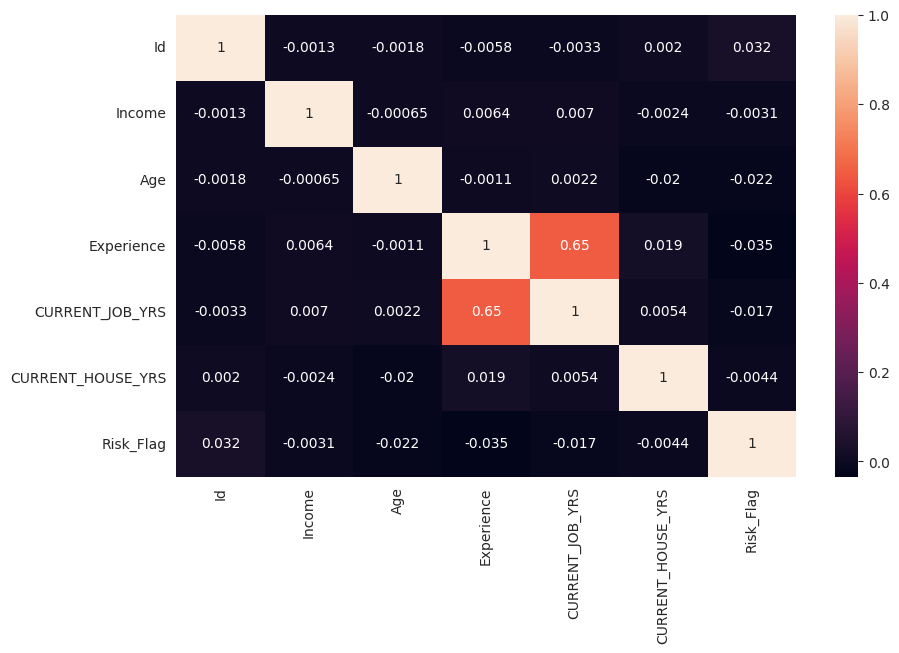

In [ ]:
# Select only numerical columns for correlation calculation
df_numeric = df.select_dtypes(include=np.number)

# Calculate and plot the heatmap for numerical columns
sns.heatmap(df_numeric.corr(), annot=True);

###ID feature

In [ ]:
df.drop("Id", axis=1, inplace=True)


Based on heatmap, there is no correlation between ID column and other features. It's just row identifier. WE should drop this column.

###Income

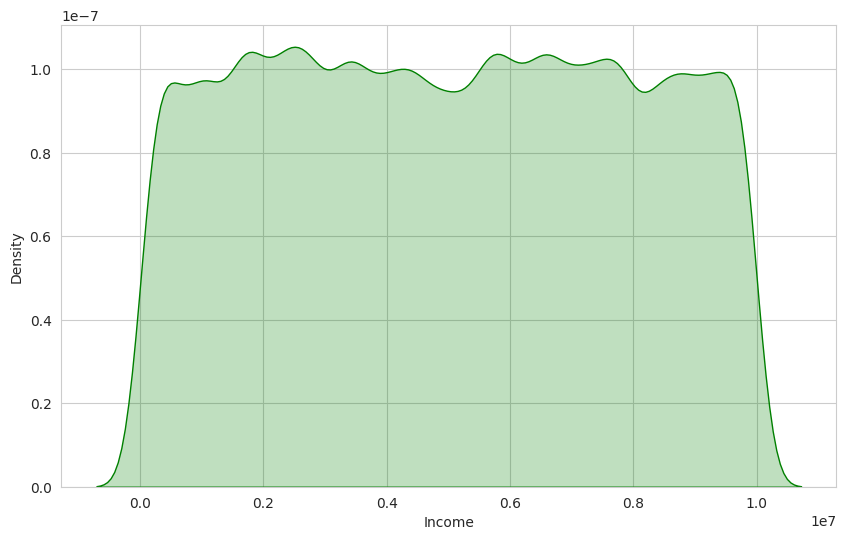

In [ ]:
sns.kdeplot(df.Income, color='green',shade=True);

A KDE plot is a way to visualize the distribution of a single numerical variable. It shows the probability density function of the data, which can help you understand the shape of the distribution, identify peaks (modes), and see the spread of the data. In this case, it will show you the distribution of income values in your dataset.

In [ ]:
df.groupby("Profession")["Income"].agg(["min", "max", "mean", "std"]).sort_values(by="mean", ascending=False)

"""
This line of code is performing an analysis of the Income column based on the Profession
of individuals in your dataset.
"""

,min,max,mean,std
Profession,,,,
Petroleum_Engineer,22921,9968353,5443309.827,2947683.213
Psychologist,33224,9985964,5357795.262,2815681.793
Designer,12841,9996946,5336802.230,2955188.103
Scientist,13792,9975985,5282710.423,2861046.111
Surgeon,18215,9995445,5235358.713,2831574.156
...,...,...,...,...
Civil_engineer,25674,9992141,4755441.023,2811661.895
Official,13629,9993041,4737617.356,2933763.750
Drafter,14936,9999180,4654804.628,2789440.541


'\nThis line of code is performing an analysis of the Income column based on the Profession \nof individuals in your dataset.\n'

###Age

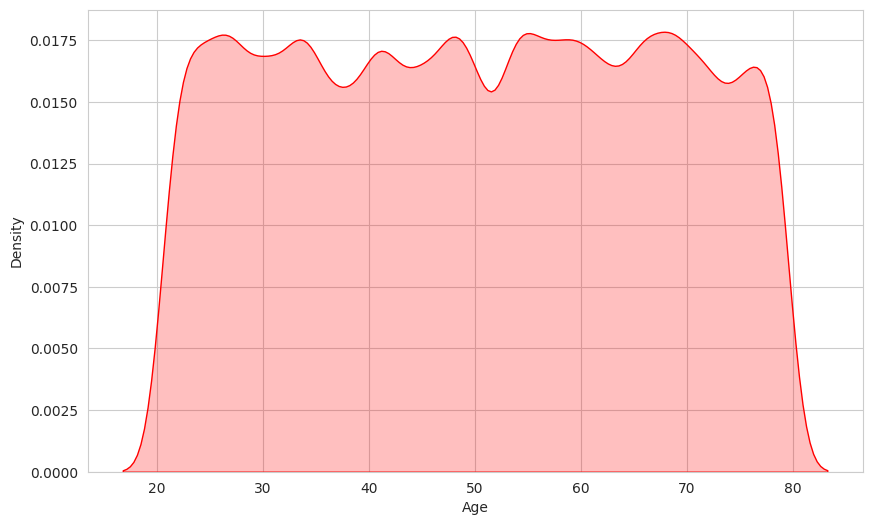

In [ ]:
sns.kdeplot(df.Age, color='red',shade=True);

###Experience

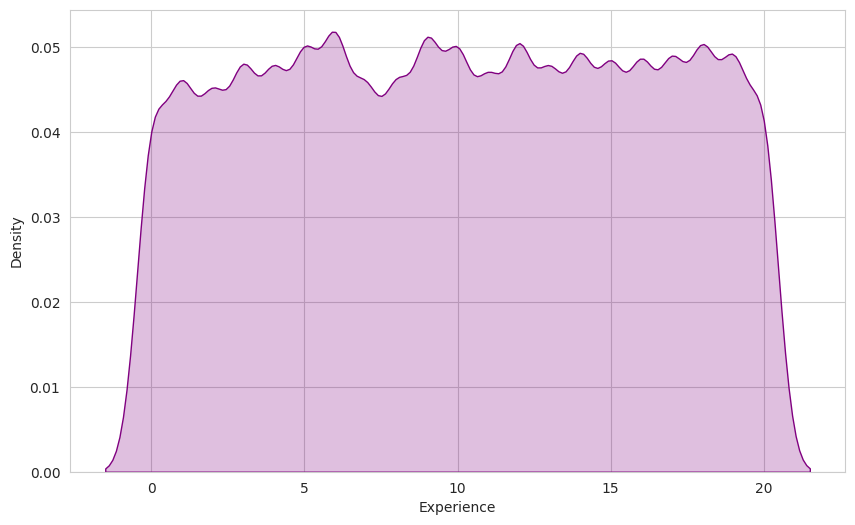

In [ ]:
sns.kdeplot(df.Experience, color='purple',shade=True);

###Married / single

In [ ]:
# Renaming column to avoid trouble
df.rename(columns={"Married/Single":"Married_Single"}, inplace=True)
df.head(5)
print("\nMarital status ( Count and Percentage):\n ")
# Marital status ( Count and Percentage)
marital_stat_c = df["Married_Single"].value_counts()
marital_stat_p = (marital_stat_c /len(df)) * 100
marital_stat = pd.concat([marital_stat_c, marital_stat_p], axis=1)
marital_stat.columns = ["Count", "Percentage"]
marital_stat

,Income,Age,Experience,Married_Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1



Marital status ( Count and Percentage):
 


,Count,Percentage
Married_Single,,
single,226272,89.790
married,25728,10.210


Grouping Marital status by Risk flag can give us insightful outcome.

In [ ]:
# Group by 'Married_Single' and 'Risk_Flag' and count the occurrences
marital_risk_counts = df.groupby(['Married_Single', 'Risk_Flag']).size().unstack(fill_value=0).sort_values(by=1, ascending=False)

# the average risk percentage according to the marital status
marital_risk_percentages = df.groupby('Married_Single').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T

# If Risk_Flag 0 means No Risk and 1 means Risk:
marital_risk_counts.columns = ['No_Risk', 'Risk']

# Display the resulting table
marital_risk_counts
print("\nRisk_Flag:\n")
marital_risk_percentages


,No_Risk,Risk
Married_Single,,
single,197912,28360
married,23092,2636



Risk_Flag:



Married_Single,single,married
Risk_Flag,12.534,10.246


Text(0.5, 1.0, 'Distribution of the target variable according to maritial status')

[Text(0, 0, '197912'), Text(0, 0, '23092')]

[Text(0, 0, '28360'), Text(0, 0, '2636')]

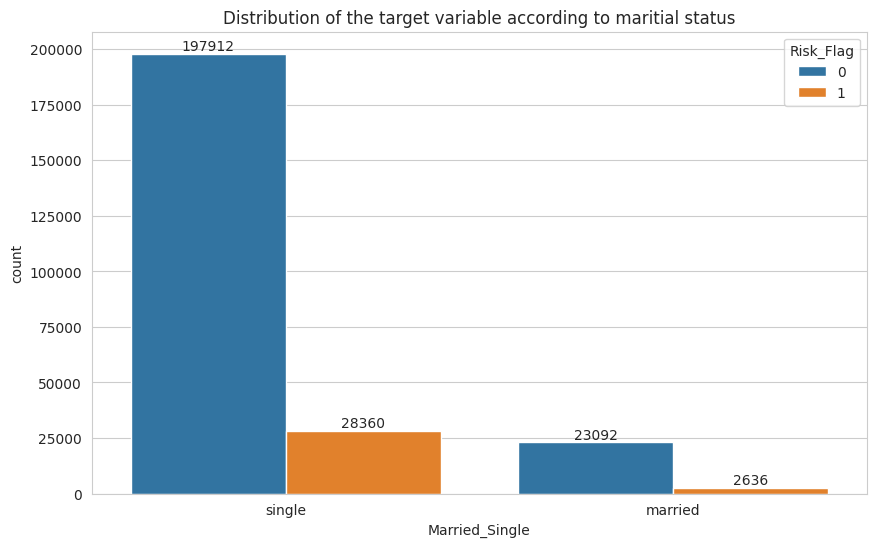

In [ ]:
ax = sns.countplot(data = df , x=df["Married_Single"], hue= "Risk_Flag")
plt.title('Distribution of the target variable according to maritial status')
for p in ax.containers:
    ax.bar_label(p)

###House Ownership

In [ ]:
House_ownership_count = df["House_Ownership"].value_counts()
print(House_ownership_count)

House_Ownership
rented          231898
owned            12918
norent_noown      7184
Name: count, dtype: int64


In [ ]:
df_nohouse_prof = df[df["House_Ownership"] == "norent_noown"]["Profession"].value_counts()
print(df_nohouse_prof)

Profession
Software_Developer     329
Surveyor               319
Biomedical_Engineer    248
Scientist              244
Web_designer           241
                      ... 
Secretary               56
Lawyer                  54
Technical_writer        50
Psychologist            41
Official                26
Name: count, Length: 51, dtype: int64


In [ ]:
print("relationship between years a person employes in their current job and their house ownership status:\n")
df_JOB_YRS_house = pd.crosstab([df.CURRENT_JOB_YRS], df.House_Ownership)
print(df_JOB_YRS_house)

relationship between years a person employes in their current job and their house ownership status:

House_Ownership  norent_noown  owned  rented
CURRENT_JOB_YRS                             
0                         489    386   10168
1                         155    394   11026
2                         425    619   10043
3                         563   2081   26816
4                         774   1716   25849
5                         925   1022   23144
6                         715   1152   21624
7                         491    673   18761
8                         449    837   17588
9                         442    644   16046
10                        398    931   14439
11                        561    917   12117
12                        109    650    9846
13                        288    383    8428
14                        400    513    6003


In [ ]:
df.groupby('House_Ownership').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
# the average risk percentage according to the house ownership status

House_Ownership,rented,norent_noown,owned
Risk_Flag,12.558,9.953,8.980


###Car Ownership

In [ ]:
print("Car ownership status:\n")
df_Car = df["Car_Ownership"].value_counts()
print(df_Car)

print("\nThe average risk percentage according to the car ownership status:\n")
Car_Own_risk = df.groupby('Car_Ownership').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
Car_Own_risk
# the average risk percentage according to the car ownership status

Car ownership status:

Car_Ownership
no     176000
yes     76000
Name: count, dtype: int64

The average risk percentage according to the car ownership status:



Car_Ownership,no,yes
Risk_Flag,12.819,11.099


Relation between car ownership and risk flag indicates there is more people with no car and they are also have high rate of loan default risk than whome has car.

###Profession

In [ ]:
print("Number of person working in profession:\n")
Profession = df["Profession"].value_counts()
print(Profession)

print("\nThe average risk percentage according to the profession:\n")
df.groupby('Profession').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False)
# the average risk percentage of each profession

Number of person working in profession:

Profession
Physician                     5957
Statistician                  5806
Web_designer                  5397
Psychologist                  5390
Computer_hardware_engineer    5372
                              ... 
Firefighter                   4507
Chartered_Accountant          4493
Civil_servant                 4413
Official                      4087
Engineer                      4048
Name: count, Length: 51, dtype: int64

The average risk percentage according to the profession:



,Risk_Flag
Profession,
Police_officer,16.405
Chartered_Accountant,15.357
Army_officer,15.211
Surveyor,15.146
Software_Developer,14.843
...,...
Financial_Analyst,10.315
Economist,9.928
Industrial_Engineer,9.867


###CITY

In [ ]:
df["CITY"].value_counts()
df.groupby('CITY').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).head(50).to_frame().T


In [ ]:
df.groupby(['STATE', "CITY"]).Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False)


###STATE

In [ ]:
df["STATE"].value_counts()


,count
STATE,
Uttar_Pradesh,28400
Maharashtra,25562
Andhra_Pradesh,25297
West_Bengal,23483
Bihar,19780
...,...
Himachal_Pradesh,833
Tripura,809
Uttar_Pradesh[5],743


The third row from the bottom caught my attention. There is a specific state called "Uttar Pradesh," and it is also listed as "Uttar Pradesh[5]." We need to merge these two entries together.
Additionally, we should look for similarities in other states to improve the dataset.

In [42]:
print("Unique values in 'STATE' column:")
print(df['STATE'].unique())

Unique values in 'STATE' column:
['Madhya_Pradesh' 'Maharashtra' 'Kerala' 'Odisha' 'Tamil_Nadu' 'Gujarat'
 'Rajasthan' 'Telangana' 'Bihar' 'Andhra_Pradesh' 'West_Bengal' 'Haryana'
 'Puducherry' 'Karnataka' 'Uttar_Pradesh' 'Himachal_Pradesh' 'Punjab'
 'Tripura' 'Uttarakhand' 'Jharkhand' 'Mizoram' 'Assam' 'Jammu_and_Kashmir'
 'Delhi' 'Chhattisgarh' 'Chandigarh' 'Uttar_Pradesh[5]' 'Manipur' 'Sikkim']


There is no other similarity. Using lambda function to modify STATE column.

In [44]:
df["STATE"] = df["STATE"].apply(lambda x: "Uttar_Pradesh" if x == "Uttar_Pradesh[5]" else x)
df["STATE"].value_counts()

,count
STATE,
Uttar_Pradesh,29143
Maharashtra,25562
Andhra_Pradesh,25297
West_Bengal,23483
Bihar,19780
...,...
Manipur,849
Himachal_Pradesh,833
Tripura,809


In [46]:
print("The average risk percentage according to the state:\n")
df.groupby('STATE').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
# the average risk percentage of each state

The average risk percentage according to the state:



STATE,Manipur,Tripura,Kerala,Jammu_and_Kashmir,Madhya_Pradesh,Odisha,Rajasthan,Jharkhand,Chhattisgarh,Himachal_Pradesh,Assam,Bihar,Telangana,West_Bengal,Haryana,Uttar_Pradesh,Gujarat,Puducherry,Andhra_Pradesh,Maharashtra,Mizoram,Delhi,Tamil_Nadu,Karnataka,Chandigarh,Punjab,Uttarakhand,Sikkim
Risk_Flag,21.555,16.811,16.710,15.899,15.437,14.255,14.083,13.330,13.328,13.325,13.169,13.059,13.012,12.814,12.421,11.804,11.772,11.654,11.602,11.325,11.072,10.455,10.316,10.030,9.299,9.004,7.097,4.605


###CURRENT JOB YEARS

In [55]:
print("Number of person working in same current job years in :\n")
df["CURRENT_JOB_YRS"].value_counts()

print("\nThe average risk percentage according to the current job years:\n")
df.groupby('CURRENT_JOB_YRS').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
# the average risk percentage according to the current job years


Number of person working in same current job years in :



,count
CURRENT_JOB_YRS,
3,29460
4,28339
5,25091
6,23491
7,19925
8,18874
9,17132
10,15768
11,13595



The average risk percentage according to the current job years:



CURRENT_JOB_YRS,2,1,0,13,11,6,10,5,14,7,3,8,4,9,12
Risk_Flag,17.047,15.568,14.326,13.969,13.255,12.217,11.923,11.845,11.813,11.769,11.578,11.556,11.317,10.799,10.523


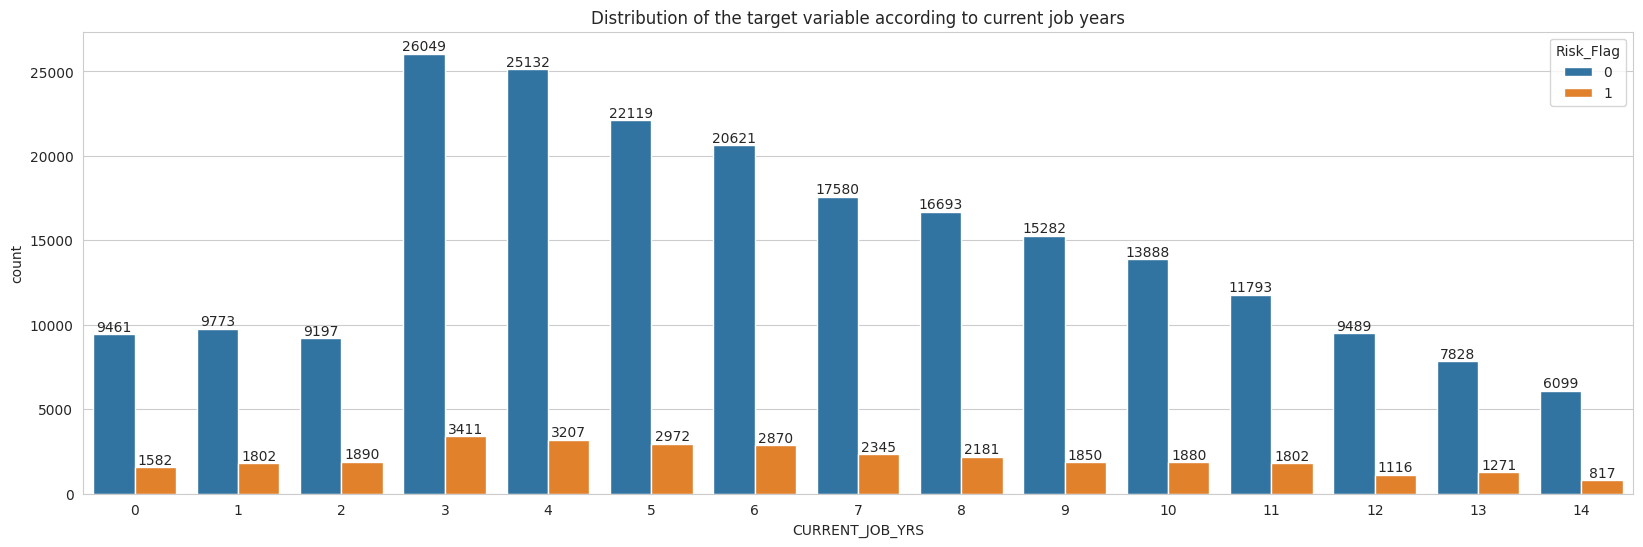

In [75]:
plt.figure(figsize=(20,6));
ax = sns.countplot(data = df , x=df["CURRENT_JOB_YRS"].sort_values(), hue= "Risk_Flag");
plt.title('Distribution of the target variable according to current job years');
for bars in ax.containers:
        ax.bar_label(bars);
plt.show();

###Risk Flag

In [76]:
## Analyzing the Distribution of the Target Variable with Percentages

print("Risk Flag Distribution (Count and Percentage):\n")

# Get the value counts
risk_flag_counts = df["Risk_Flag"].value_counts()

# Calculate the percentages
risk_flag_percentages = df["Risk_Flag"].value_counts(normalize=True) * 100

# Combine counts and percentages into a single table
risk_flag_distribution = pd.concat([risk_flag_counts, risk_flag_percentages], axis=1)

# Rename the columns for clarity
risk_flag_distribution.columns = ["Count", "Percentage"]

# Display the table
print(risk_flag_distribution)

Risk Flag Distribution (Count and Percentage):

            Count  Percentage
Risk_Flag                    
0          221004      87.700
1           30996      12.300


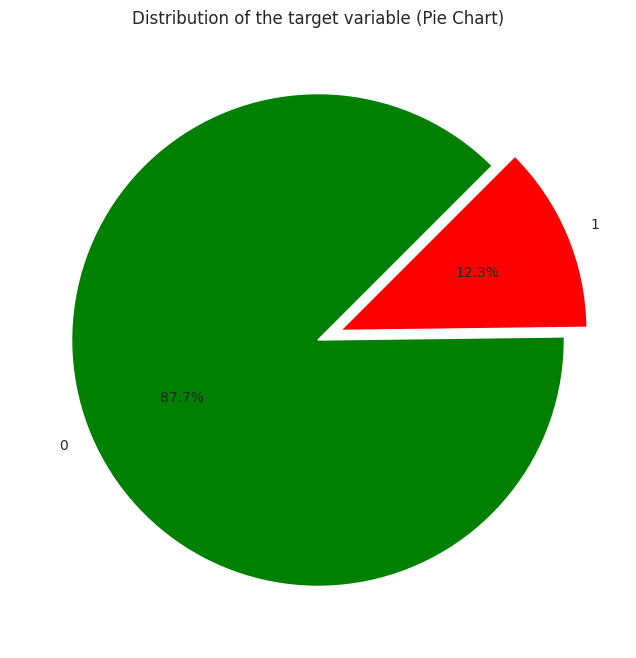

In [74]:
## Plotting the Pie Chart for Risk Flag Distribution

# Create a new figure for the pie chart
plt.figure(figsize=(8,8)); # A square figure is often better for pie charts

# Generate the pie chart
plt.pie(df.Risk_Flag.value_counts(), labels = df.Risk_Flag.value_counts().index, autopct = '%1.1f%%', startangle = 45, explode = (0, 0.1), colors = ['green', 'red'] );
plt.title('Distribution of the target variable (Pie Chart)'); # Title for the pie chart

# Display this figure
plt.show();

There is a significant difference between Risk and No Risk values, indicating that we are dealing with an imbalanced dataset, which is common in business analysis.

In [82]:
# Select only numerical columns for correlation calculation
df_numeric = df.select_dtypes(include=np.number)

# Calculate the correlation with the target variable
correlation_with_risk_flag = df_numeric.corr()['Risk_Flag'].drop('Risk_Flag')

# Display the correlation values with styling
print("Correlation with Risk_Flag (Styled Table):")

# Apply styling to highlight values
# Use background_gradient to color cells based on their value

styled_correlation = correlation_with_risk_flag.sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm')

# Display the styled output
display(styled_correlation)

Correlation with Risk_Flag (Styled Table):


,Risk_Flag
Income,-0.003091
CURRENT_HOUSE_YRS,-0.004375
CURRENT_JOB_YRS,-0.016942
Age,-0.021809
Experience,-0.034523


The table shows the correlation between numerical features and the target variable Risk_Flag. All values are negative, indicating a slight inverse relationship — as these feature values increase, the likelihood of loan default slightly decreases. However, the correlations are weak, suggesting that default risk is influenced by more complex, non-linear patterns across multiple variables. (As shown in heatmap earlier)

#Developing Model